# Финальное задание по классификации изображений

Импортируем как обычно вспомогательные библиотеки:

In [118]:
#!g1.1
%matplotlib inline
%load_ext tensorboard


import os
import random
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

 
import torch
import torchvision
import pytorch_lightning as pl

print(pl.__version__)
print(torch.__version__)
print(torchvision.__version__)

BATCH_SIZE = 32

1.2.0
1.9.1+cu111
0.10.1+cu111


## Подготовка данных


In [ ]:
#!g1.1
!unzip CV_project1_data.zip

In [121]:
#!g1.1
!ls data/train

bill_gates  elon_musk  jeff_bezos  mark_zuckerberg  steve_jobs


In [123]:
#!g1.1
!find data/train -type f | wc -l

3000


Создаем объекты датасетов для обучения и валидации:

In [124]:
#!g1.1
from copy import copy
train_dataset = torchvision.datasets.ImageFolder("data/train/")
valid_dataset = torchvision.datasets.ImageFolder("data/valid/")
idx_to_class = {i: c for c, i in train_dataset.class_to_idx.items()}

print(len(train_dataset), len(valid_dataset))

3000 914


In [125]:
#!g1.1
idx_to_class

{0: 'bill_gates',
 1: 'elon_musk',
 2: 'jeff_bezos',
 3: 'mark_zuckerberg',
 4: 'steve_jobs'}


Посмотрим на примеры из обучения и валидации:

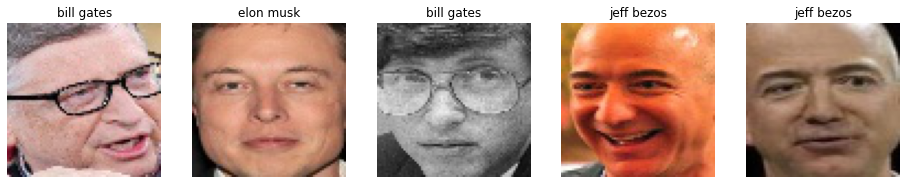

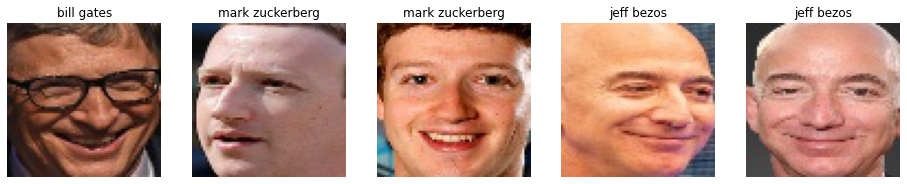

In [126]:
#!g1.1
def plot_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(16, 8))

    for i in range(num_samples):
        random_image, random_class = random.choice(dataset)
        random_label = dataset.classes[random_class]
        axes[i].imshow(random_image)
        axes[i].set_title(random_label.replace("_", " "))
        axes[i].axis("off")

    plt.show()

plot_samples(train_dataset)
plot_samples(valid_dataset)

Определим также даталоадеры для обучения и валидации:

In [127]:
#!g1.1
from torchvision import transforms

from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_dataset.transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
valid_dataset.transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count()
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count()
)

## Обучение модели

In [128]:
#!g1.1
def train_model(net, optimizer, train_dataset, valid_dataset, num_epochs=10):
    loss_train = []
    top1_train = []
    loss_valid = []
    top1_valid = []

    for epoch in range(num_epochs):
        print('Epoch', epoch)
        torch.set_grad_enabled(True)
        net.train()

        losses = []
        equals = []

        for i, (images, target) in enumerate(tqdm(train_loader)):
            images = images.to(device)
            target = target.to(device)
            output = net(images)
            loss = criterion(output, target)

            losses.append(loss.item())
            equals.extend([eq.item() for eq in output.argmax(1) == target])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_train.append(np.mean(losses))
        top1_train.append(np.mean(equals))

        torch.set_grad_enabled(False)
        net.eval()

        losses = []
        equals = []

        for i, (images, target) in enumerate(tqdm(valid_loader)):
            images = images.to(device)
            target = target.to(device)

            output = net(images)
            loss = criterion(output, target)

            losses.append(loss.item())
            equals.extend([eq.item() for eq in output.argmax(1) == target])

            
        loss_valid.append(np.mean(losses))
        top1_valid.append(np.mean(equals))

        print('loss/train', loss_train[-1])
        print('top1/train', top1_train[-1])
        print('loss/valid', loss_valid[-1])
        print('top1/valid', top1_valid[-1])
        
    return loss_train, top1_train, loss_valid, top1_valid

Воспользуемся предобученным resnet34, заморозим веса, и заменим последний полносвязный слой

In [131]:
#!g1.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = torchvision.models.resnet34(pretrained=True)
for parameter in net.parameters():
    parameter.requres_grad = False
net.fc = torch.nn.Linear(512, len(train_dataset.classes))
net = net.to(device)

Начинаем обучение сети:

In [133]:
#!g1.1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-3, weight_decay=1e-4)

loss_train, top1_train, loss_valid, top1_valid = train_model(net, optimizer, train_dataset, valid_dataset, 50)

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 0


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 1.5320484143622377
top1/train 0.32866666666666666
loss/valid 1.3489230562900674
top1/valid 0.4803063457330416
Epoch 1


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 1.2978091113110806
top1/train 0.49766666666666665
loss/valid 1.0872280803220025
top1/valid 0.6531728665207878
Epoch 2


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 1.1329579575264708
top1/train 0.5936666666666667
loss/valid 0.8968530204789392
top1/valid 0.7396061269146609
Epoch 3


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.9890076816082001
top1/train 0.6563333333333333
loss/valid 0.7559584708049379
top1/valid 0.787746170678337
Epoch 4


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.8899453954493746
top1/train 0.6926666666666667
loss/valid 0.5977421947594347
top1/valid 0.8588621444201313
Epoch 5


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.7839732835901544
top1/train 0.734
loss/valid 0.5056596346970262
top1/valid 0.8719912472647703
Epoch 6


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.7172108359159307
top1/train 0.7643333333333333
loss/valid 0.41882725162752743
top1/valid 0.8916849015317286
Epoch 7


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.6655729200611723
top1/train 0.7826666666666666
loss/valid 0.37385108810046624
top1/valid 0.9015317286652079
Epoch 8


 59%|█████▊    | 17/29 [00:00<00:01,  7.17it/s]

loss/train 0.5983737396432999
top1/train 0.801
loss/valid 0.3180637236299186
top1/valid 0.9168490153172867
Epoch 9


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.5357320717674621
top1/train 0.823
loss/valid 0.26702221354533884
top1/valid 0.9266958424507659
Epoch 10


 86%|████████▌ | 25/29 [00:01<00:00, 12.43it/s]

loss/train 0.513948253177582
top1/train 0.8346666666666667
loss/valid 0.23838039705979414
top1/valid 0.936542669584245
Epoch 11


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.4605603430499422
top1/train 0.8523333333333334
loss/valid 0.20990126014783464
top1/valid 0.9452954048140044
Epoch 12


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.44707053329082247
top1/train 0.8506666666666667
loss/valid 0.20210180637137642
top1/valid 0.9431072210065645
Epoch 13


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.4245789149340163
top1/train 0.8606666666666667
loss/valid 0.17061736550310563
top1/valid 0.9551422319474836
Epoch 14


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.39001079934074523
top1/train 0.8646666666666667
loss/valid 0.15760297739300236
top1/valid 0.9595185995623632
Epoch 15


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.36429520300094115
top1/train 0.8736666666666667
loss/valid 0.14265272072676954
top1/valid 0.9617067833698031
Epoch 16


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.3768669460365113
top1/train 0.875
loss/valid 0.13669733805903073
top1/valid 0.9617067833698031
Epoch 17


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.3295437851326263
top1/train 0.8916666666666667
loss/valid 0.13043673362197547
top1/valid 0.9649890590809628
Epoch 18


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.34163180009481753
top1/train 0.8866666666666667
loss/valid 0.11532816554194894
top1/valid 0.9704595185995624
Epoch 19


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.32654846039541224
top1/train 0.8873333333333333
loss/valid 0.11493042599538277
top1/valid 0.9671772428884027
Epoch 20


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.31221720061086594
top1/train 0.8983333333333333
loss/valid 0.09934689422491295
top1/valid 0.973741794310722
Epoch 21


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.31596159839883764
top1/train 0.8923333333333333
loss/valid 0.0976191237890001
top1/valid 0.9704595185995624
Epoch 22


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.2915582335851294
top1/train 0.903
loss/valid 0.09095994810220497
top1/valid 0.973741794310722
Epoch 23


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.2889743370420121
top1/train 0.902
loss/valid 0.09148176537890887
top1/valid 0.973741794310722
Epoch 24


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.2851820675299523
top1/train 0.9083333333333333
loss/valid 0.08715489805387013
top1/valid 0.973741794310722
Epoch 25


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.26792400790021775
top1/train 0.9053333333333333
loss/valid 0.07943359039852331
top1/valid 0.9792122538293216
Epoch 26


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.2606110235953585
top1/train 0.9153333333333333
loss/valid 0.0803059649107785
top1/valid 0.975929978118162
Epoch 27


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.2554345191951762
top1/train 0.9146666666666666
loss/valid 0.07682800222316692
top1/valid 0.9770240700218819
Epoch 28


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.251987616590997
top1/train 0.9153333333333333
loss/valid 0.07523915255121116
top1/valid 0.975929978118162
Epoch 29


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.26434661352888067
top1/train 0.9076666666666666
loss/valid 0.06922599700568564
top1/valid 0.9792122538293216
Epoch 30


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.23144120885495176
top1/train 0.9186666666666666
loss/valid 0.06841286787249405
top1/valid 0.9835886214442013
Epoch 31


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.22786235329794122
top1/train 0.93
loss/valid 0.07240673295896628
top1/valid 0.9792122538293216
Epoch 32


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.24224745862661523
top1/train 0.9173333333333333
loss/valid 0.06204482585448643
top1/valid 0.9857768052516411
Epoch 33


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.22461622358953698
top1/train 0.92
loss/valid 0.05975418781925892
top1/valid 0.9846827133479212
Epoch 34


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.2159792375453609
top1/train 0.9263333333333333
loss/valid 0.05562851939286138
top1/valid 0.9846827133479212
Epoch 35


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.21420797733391853
top1/train 0.931
loss/valid 0.059751214170507314
top1/valid 0.9835886214442013
Epoch 36


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.20932681846650356
top1/train 0.9246666666666666
loss/valid 0.056755519584463586
top1/valid 0.9857768052516411
Epoch 37


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.20150987257031686
top1/train 0.9316666666666666
loss/valid 0.05744858857661743
top1/valid 0.9835886214442013
Epoch 38


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.20382273046577232
top1/train 0.9303333333333333
loss/valid 0.05697754311278976
top1/valid 0.9857768052516411
Epoch 39


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.22619078704651366
top1/train 0.9203333333333333
loss/valid 0.05537811530240137
top1/valid 0.9835886214442013
Epoch 40


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.1888285395392078
top1/train 0.937
loss/valid 0.0554030932132797
top1/valid 0.9824945295404814
Epoch 41


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.21309630620352765
top1/train 0.927
loss/valid 0.05348504246373115
top1/valid 0.9846827133479212
Epoch 42


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.18817120207909574
top1/train 0.94
loss/valid 0.05402037149680586
top1/valid 0.9835886214442013
Epoch 43


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.1923000279496959
top1/train 0.935
loss/valid 0.04715945688076317
top1/valid 0.9846827133479212
Epoch 44


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.20335950611278097
top1/train 0.9283333333333333
loss/valid 0.048924840761926665
top1/valid 0.9890590809628009
Epoch 45


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.18183276227655562
top1/train 0.939
loss/valid 0.053731688153769434
top1/valid 0.9846827133479212
Epoch 46


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.1748526699920284
top1/train 0.9453333333333334
loss/valid 0.05028184533022858
top1/valid 0.986870897155361
Epoch 47


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.17214680922792314
top1/train 0.94
loss/valid 0.0500809444628399
top1/valid 0.9846827133479212
Epoch 48


  0%|          | 0/94 [00:00<?, ?it/s]

loss/train 0.17730005061689844
top1/train 0.9446666666666667
loss/valid 0.05248429574843111
top1/valid 0.986870897155361
Epoch 49


100%|██████████| 29/29 [00:01<00:00, 21.97it/s]


loss/train 0.1841958122169401
top1/train 0.9373333333333334
loss/valid 0.048328169011350335
top1/valid 0.9879649890590809


Финальные результаты обучения:

loss/train 0.1841958122169401

top1/train 0.9373333333333334

loss/valid 0.048328169011350335

top1/valid 0.9879649890590809

Посмотрим графики функции потерь и точности. Красный цвет - валидационная выборка, синий - тренировочная

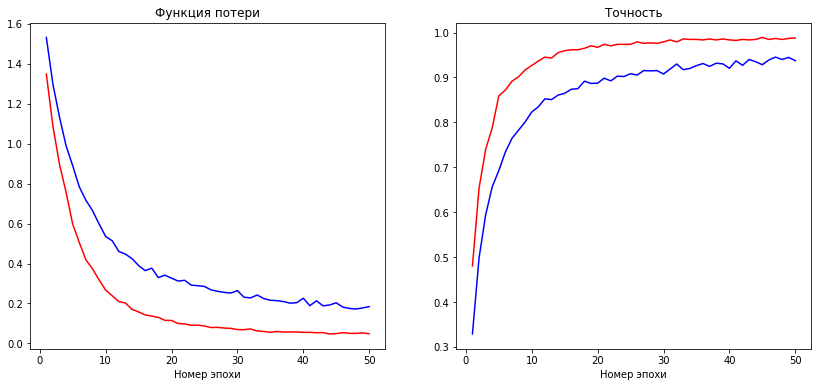

In [134]:
#!g1.1
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(range(1, len(loss_train) + 1), loss_train, color="b")
plt.plot(range(1, len(loss_train) + 1), loss_valid, color="r")
plt.xlabel("Номер эпохи")
plt.title("Функция потери")

plt.subplot(122)
plt.plot(range(1, len(loss_train) + 1), top1_train, color="b")
plt.plot(range(1, len(loss_train) + 1), top1_valid, color="r")
plt.xlabel("Номер эпохи")
plt.title("Точность")

plt.show()